In [1]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.8 MB/s 
     |████████████████████████████████| 6.3 MB 23.6 MB/s 
     |████████████████████████████████| 16.7 MB 256 kB/s 


In [2]:
!pip install mgwr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 641 kB/s 
     |████████████████████████████████| 2.4 MB 12.4 MB/s 
     |████████████████████████████████| 209 kB 44.9 MB/s 
  Created wheel for mgwr: filename=mgwr-2.1.2-py3-none-any.whl size=46386 sha256=571abf8cc71145ac15ee52b9bbf2813f60c01921566fac3a7f5475b95f14ceb8
  Stored in directory: /root/.cache/pip/wheels/e8/55/57/c1bf993ab0ab4b9885ac1fdf7f9f960397355cf889b77a3e4b
  Created wheel for spglm: filename=spglm-1.0.8-py3-none-any.whl size=38806 sha256=4181837bf2f9de0b2cfe771ec84cafcb8092dee4ea168a831051137b1d6560cc
  Stored in directory: /root/.cache/pip/wheels/29/79/e9/453e3b0d858bed16e097c6e6bbd75e2b966bfcfb21b12790d0
Successfully built mgwr spglm


In [3]:
pip install esda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 116 kB 8.1 MB/s 
  Created wheel for esda: filename=esda-2.4.3-py3-none-any.whl size=122781 sha256=86e7d6828557e8dcc76f264b18fa8e3a7da8d52115807e66add9843a0f2d202c
  Stored in directory: /root/.cache/pip/wheels/37/07/2e/2aa4874ca25fa442a3912c74e53780da19d25ec1d58bac5d30
Successfully built esda


In [4]:
pip install splot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 8.1 MB/s 
     |████████████████████████████████| 179 kB 59.8 MB/s 


In [5]:
pip install libpysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from geopandas import GeoDataFrame
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sms
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans # import k-means from clustering stage
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap,truncate_colormap
import esda
import libpysal as lps
from esda.moran import Moran_Local
from splot.esda import plot_moran
from scipy.stats.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression

In [7]:
test_2021 = pd.read_csv('/content/EV_Demand.csv')

In [8]:
ncr_points = pd.read_csv('/content/national-charge-point-registry.csv')

# Data Preprocessing

## MOT Data

In [9]:
test_2021 = test_2021.sort_values('test_date').drop_duplicates('vehicle_id', keep='last')

In [10]:
test_2021 = test_2021[test_2021['last_test_mileage'] != 0]

In [11]:
test_2021 = test_2021[test_2021['driven_mileage'] > 0]

In [12]:
test_2021 = test_2021[test_2021['driven_mileage'] >= test_2021['real_range (Miles)']]

In [13]:
test_2021.sort_values(by='driven_mileage')

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,...,first_use_date,last_test_mileage,driven_mileage,battery_size (kWh),real_range (Miles),charging_fre,electricity_demand (kWh),cost_to_charge,cost_per_mile,cost_overall
3027,214376349,364233295,2021/1/20,4,NT,F,8627,DE,AIXAM,MEGA,...,2008/6/1,8572,55,3.24,37,1,5,0.9072,0.024519,1.348541
19914,308642993,1370749591,2021/5/6,4,NT,P,1827,EH,RENAULT,TWIZY,...,2013/11/29,1770,57,6.10,56,1,6,1.7080,0.030500,1.738500
19733,1328234885,550779403,2021/5/5,4,NT,P,2870,EH,RENAULT,TWIZY,...,2012/12/28,2812,58,6.10,56,1,6,1.7080,0.030500,1.769000
31567,1146027985,218772892,2021/7/27,4,NT,P,16096,KT,RENAULT,TWIZY,...,2012/4/18,16035,61,6.10,56,1,7,1.7080,0.030500,1.860500
42808,1269676389,930513336,2021/9/20,4,NT,P,11750,UB,REVA,G-WIZ,...,2006/3/15,11686,64,9.60,48,1,13,2.6880,0.056000,3.584000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2806,1841093305,175356981,2021/1/19,4,RT,P,132913,AB,NISSAN,LEAF,...,2013/7/31,11337,121576,24.00,80,1520,36473,6.7200,0.084000,10212.384000
58093,55595053,1366418469,2021/11/19,4,NT,P,137209,BA,RENAULT,KANGOO,...,2016/9/26,8205,129004,22.00,81,1593,35038,6.1600,0.076049,9810.674568
4906,825691317,1076945147,2021/2/1,4,NT,P,180069,LL,NISSAN,E-NV200,...,2017/1/26,11323,168746,24.00,65,2596,62306,6.7200,0.103385,17445.740310
42526,1588428995,1167186155,2021/9/20,4,NT,P,207278,RG,RENAULT,ZOE,...,2016/9/13,23808,183470,25.90,87,2109,54619,7.2520,0.083356,15293.384370


In [14]:
test_2021= test_2021[(test_2021["electricity_demand (kWh)"] < np.percentile(test_2021["electricity_demand (kWh)"], q = 99 ))]

In [15]:
postcode_mile = test_2021.groupby('postcode_area')['electricity_demand (kWh)'].sum().reset_index()

In [16]:
test_2021['cost_per_mile'] = pd.to_numeric(test_2021['cost_per_mile'])

In [17]:
p_kWh = postcode_mile.sort_values(by='electricity_demand (kWh)',ascending = False)

In [18]:
p_BEV = test_2021.groupby('postcode_area')['vehicle_id'].count().reset_index()

In [19]:
merged_bev = pd.merge(p_kWh,p_BEV,how = 'left', on='postcode_area')

In [20]:
merged_bev

,postcode_area,electricity_demand (kWh),vehicle_id
0,NW,1740229,941
1,BS,1685833,1034
2,GL,1575468,717
3,B,1477457,739
4,NE,1431530,698
...,...,...,...
114,DG,79878,42
115,XX,36831,21
116,ZE,34014,17
117,HS,27925,10


## Charger Stations Data

In [21]:
ncr_points = ncr_points[ncr_points['chargeDeviceStatus'] == "In service"]

In [22]:
postcode_supply = ncr_points.groupby('postcode_area')['overall_kWh'].sum().reset_index()

In [23]:
fast_charger = ncr_points.groupby('postcode_area')['fast_chargers_num'].sum().reset_index()

In [24]:
charging_kWh = postcode_supply.sort_values(by='overall_kWh',ascending = False)

In [25]:
charging_points = ncr_points.groupby('postcode_area')['in_service_connect'].sum().reset_index()

In [26]:
merged_charger = pd.merge(charging_kWh,charging_points,how = 'left', on='postcode_area')

In [27]:
merged_charger = pd.merge(merged_charger,fast_charger,how = 'left', on='postcode_area')

In [28]:
merged_charger

,postcode_area,overall_kWh,in_service_connect,fast_chargers_num
0,SW,22474.3,2802,811
1,NE,19747.0,1016,661
2,W,19540.3,2812,581
3,MK,19219.1,868,572
4,NG,17353.0,876,660
...,...,...,...,...
118,TF,702.8,38,26
119,LD,682.0,30,26
120,ZE,644.0,40,34
121,IM,392.0,41,41


## Car Availability

In [29]:
car = pd.read_csv('/content/Car or van availability.csv')

In [30]:
car

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Postcode_Area,Car or van availability : Total\ Car or van availability - Unit : Households,Car or van availability : Total\ Car or van availability - Unit : Cars or vans,Car or van availability : No cars or vans in household - Unit : Households,Car or van availability : 1 car or van in household - Unit : Households,Car or van availability : 2 cars or vans in household - Unit : Households,Car or van availability : 3 cars or vans in household - Unit : Households,Car or van availability : 4 or more cars or vans in household - Unit : Households,Car or van availability : Sum of all cars or vans - Unit : Cars or vans
0,E02000001,City of London 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,WC,4385,1692.0,3043,1100,173,51,18,1692
1,E02000002,Barking and Dagenham 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,2713,2305.0,1020,1186,424,66,17,2305
2,E02000003,Barking and Dagenham 002,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,3834,3766.0,1196,1753,691,155,39,3766
3,E02000004,Barking and Dagenham 003,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,2318,2650.0,556,1085,515,128,34,2650
4,E02000005,Barking and Dagenham 004,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,3183,2937.0,1080,1423,551,109,20,2937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,S02002510,Winchburgh; Bridgend and Philpstoun,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,2012,NaN,489,893,512,86,32,2314
8476,S02002511,Broxburn Kirkhill,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,1780,NaN,473,813,388,81,25,1944
8477,S02002512,Uphall; Dechmont and Ecclesmachan,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,2485,NaN,577,1080,658,123,47,2976
8478,S02002513,Broxburn South,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,1479,NaN,246,595,515,90,33,2053


In [31]:
car.rename(columns={'Car or van availability : No cars or vans in household - Unit : Households':'No cars','Car or van availability : 1 car or van in household - Unit : Households':'1 car','Car or van availability : 2 cars or vans in household - Unit : Households':'2 cars',
                    'Car or van availability : 3 cars or vans in household - Unit : Households':'3 cars','Car or van availability : 4 or more cars or vans in household - Unit : Households':'4+ cars','Car or van availability : Sum of all cars or vans - Unit : Cars or vans':'Total Cars'}, inplace=True)

In [32]:
total_cars = car.groupby('Postcode_Area')['Total Cars'].sum().reset_index()

In [33]:
no_car = car.groupby('Postcode_Area')['No cars'].sum().reset_index()

In [34]:
one_car = car.groupby('Postcode_Area')['1 car'].sum().reset_index()

In [35]:
two_cars = car.groupby('Postcode_Area')['2 cars'].sum().reset_index()

In [36]:
three_cars = car.groupby('Postcode_Area')['3 cars'].sum().reset_index()

In [37]:
four_cars = car.groupby('Postcode_Area')['4+ cars'].sum().reset_index()

In [38]:
merged_cars = pd.merge(no_car,one_car,how = 'left', on='Postcode_Area')

In [39]:
merged_cars = pd.merge(merged_cars,two_cars,how = 'left', on='Postcode_Area')

In [40]:
merged_cars = pd.merge(merged_cars,three_cars,how = 'left', on='Postcode_Area')

In [41]:
merged_cars = pd.merge(merged_cars,four_cars,how = 'left', on='Postcode_Area')

In [42]:
merged_cars = pd.merge(merged_cars,total_cars,how = 'left', on='Postcode_Area')

In [43]:
merged_cars['prop_1_car'] = merged_cars['1 car']/merged_cars['Total Cars']

In [44]:
merged_cars['2_more_cars'] = merged_cars['2 cars'] + merged_cars['3 cars'] + merged_cars['4+ cars']

In [45]:
merged_cars['prop_2_car'] = merged_cars['2_more_cars']/merged_cars['Total Cars']

In [46]:
merged_cars = merged_cars.drop(columns=['No cars','2 cars','3 cars','3 cars','Total Cars','4+ cars'])

In [47]:
merged_cars

,Postcode_Area,1 car,prop_1_car,2_more_cars,prop_2_car
0,AB,91497,0.349228,73239,0.279540
1,AL,32229,0.339067,27377,0.288021
2,B,289967,0.386361,200225,0.266786
3,BA,64189,0.352538,50829,0.279162
4,BB,76553,0.419747,46767,0.256428
...,...,...,...,...,...
114,WR,68497,0.270460,77004,0.304050
115,WS,82437,0.326755,73022,0.289437
116,WV,84043,0.345442,68038,0.279657
117,YO,119445,0.347770,96002,0.279514


## Method of Working

In [48]:
method = pd.read_csv('/content/Method of Working.csv')

In [49]:
method

,GEO_CODE,GEO_LABEL,Postcode_Area,GEO_TYPE,GEO_TYP2,Age 16 to 74 Total,Work mainly at or from home,Underground; metro; light rail; tram,Train,Bus; minibus or coach,Taxi,Driving a car or van,Passenger in a car or van,Motorcycle; scooter or moped,Bicycle,On foot,Other method of travel to work,Not in employment
0,E02000001,City of London 001,WC,Middle Super Output Areas and Intermediate Zones,MSOAIZ,6307,436,926,274,268,44,145,12,25,252,2297,68,1560.0
1,E02000002,Barking and Dagenham 001,RM,Middle Super Output Areas and Intermediate Zones,MSOAIZ,4360,61,400,209,371,20,1122,89,23,34,123,18,1890.0
2,E02000003,Barking and Dagenham 002,RM,Middle Super Output Areas and Intermediate Zones,MSOAIZ,7149,122,599,913,498,25,1871,107,32,42,289,22,2629.0
3,E02000004,Barking and Dagenham 003,RM,Middle Super Output Areas and Intermediate Zones,MSOAIZ,4438,72,300,405,291,21,1379,94,33,39,196,17,1591.0
4,E02000005,Barking and Dagenham 004,RM,Middle Super Output Areas and Intermediate Zones,MSOAIZ,5933,81,468,450,561,20,1562,124,32,58,215,11,2351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,NaN,Angus,DD,NaN,NaN,52873,5782,23,1022,2246,281,32513,3227,122,783,5756,1118,NaN
7229,NaN,Dundee City,DD,NaN,NaN,57971,5070,17,523,8361,314,30208,4451,127,733,7709,458,NaN
7230,NaN,North Lanarkshire,G,NaN,NaN,151944,13143,75,8523,13092,2010,92410,11668,240,454,9604,725,NaN
7231,NaN,East Dunbartonshire,G,NaN,NaN,47521,4611,61,3988,3502,342,29551,2288,126,419,2264,369,NaN


In [50]:
driving = method.groupby('Postcode_Area')['Driving a car or van'].sum().reset_index()

In [51]:
passenger = method.groupby('Postcode_Area')['Passenger in a car or van'].sum().reset_index()

In [52]:
total_people = method.groupby('Postcode_Area')['Age 16 to 74 Total'].sum().reset_index()

In [53]:
tube = method.groupby('Postcode_Area')['Underground; metro; light rail; tram'].sum().reset_index()

In [54]:
bus = method.groupby('Postcode_Area')['Bus; minibus or coach'].sum().reset_index()

In [55]:
merged_methods = pd.merge(driving,passenger,how = 'left', on='Postcode_Area')

In [56]:
merged_methods = pd.merge(merged_methods,total_people,how = 'left', on='Postcode_Area')

In [57]:
merged_methods = pd.merge(merged_methods,tube,how = 'left', on='Postcode_Area')

In [58]:
merged_methods = pd.merge(merged_methods,bus,how = 'left', on='Postcode_Area')

In [59]:
merged_methods['prop_driving'] = merged_methods['Driving a car or van']/merged_methods['Age 16 to 74 Total']
merged_methods['prop_tube'] = merged_methods['Underground; metro; light rail; tram']/merged_methods['Age 16 to 74 Total']
merged_methods['prop_bus'] = merged_methods['Bus; minibus or coach']/merged_methods['Age 16 to 74 Total']

In [60]:
merged_methods = merged_methods[['Postcode_Area','prop_driving']]

In [61]:
merged_methods

,Postcode_Area,prop_driving
0,AB,0.586536
1,AL,0.371086
2,B,0.360429
3,BA,0.395009
4,BB,0.394697
...,...,...
112,WR,0.449497
113,WS,0.428511
114,WV,0.404094
115,YO,0.385416


## Income

In [62]:
income = pd.read_csv('/content/Income.csv')

In [63]:
income = income[income['Total income: Mean'] != 'not available']
income = income[income['Total income: Median'] != 'not available']

In [64]:
income['Total income: Median'] = pd.to_numeric(income['Total income: Median'])
income['Total income: Mean'] = pd.to_numeric(income['Total income: Mean'])
income['Employment income: Median'] = pd.to_numeric(income['Employment income: Median'])
income['Employment income: Mean'] = pd.to_numeric(income['Employment income: Mean'])

In [65]:
income

,Area Code,Area Name,Postcode_Area,Self-employment income: Number of individuals,Self-employment income: Mean,Self-employment income: Median,Employment income: Number of individuals,Employment income: Mean,Employment income: Median,Pension income: Number of individuals,Pension income: Mean,Pension income: Median,Total income: Number of individuals,Total income: Mean,Total income: Median
0,E06000047,County Durham UA,DH,16,19300,14100,169,28100,23500,68,18000,16100,224,29500,23700
1,E06000005,Darlington UA,DL,3,15900,11800,39,27600,22500,14,18000,15900,49,29600,23800
2,E06000001,Hartlepool UA,TS,3,21400,17100,29,27200,22600,10,16400,14600,37,28600,23200
3,E06000002,Middlesbrough UA,TS,4,18700,15700,43,26100,21900,14,18000,16000,55,28000,23300
4,E06000057,Northumberland UA,NE,14,22300,15000,110,29000,22700,60,19500,16700,161,31700,24000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,S12000028,South Ayrshire,KA,4,29300,16600,39,30800,25500,19,18800,16000,54,33000,25900
364,S12000029,South Lanarkshire,ML,10,24000,15600,129,31100,26100,42,18000,16500,162,32400,26100
365,S12000030,Stirling,FK,4,30000,15600,35,35000,26200,14,21700,18900,47,37700,27100
366,S12000039,West Dunbartonshire,G,not available,not available,not available,33,28800,25400,11,17200,16200,41,29600,25500


In [66]:
median_income = income.groupby('Postcode_Area')['Total income: Median'].mean().reset_index()

In [67]:
median_income.sort_values(by='Total income: Median',ascending=False)

,Postcode_Area,Total income: Median
108,WC,54200.000000
95,SW,39966.666667
70,NW,38200.000000
106,W,37850.000000
50,KT,33933.333333
...,...,...
101,TQ,23000.000000
102,TR,22900.000000
54,LD,22700.000000
114,WV,22500.000000


## Education

In [68]:
education = pd.read_csv('/content/Edu.csv')

In [69]:
education

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Postcode_Area,Age : Age 16 and over - Qualification; highest level of : Total\ Highest level of qualification - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : No qualifications - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Level 1 qualifications - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Level 2 qualifications - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Level 3 qualifications - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Level 4 qualifications and above - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Apprenticeships and other qualifications\ Apprenticeship - Unit : Persons,Age : Age 16 and over - Qualification; highest level of : Apprenticeships and other qualifications\ Other qualifications - Unit : Persons
0,E02000001,City of London 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,WC,6755,454,291,445,484,4618,47.0,416.0
1,E02000002,Barking and Dagenham 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,5024,1623,789,706,479,914,118.0,395.0
2,E02000003,Barking and Dagenham 002,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,7798,1778,1210,1236,847,1829,169.0,729.0
3,E02000004,Barking and Dagenham 003,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,4986,1502,800,825,539,891,163.0,266.0
4,E02000005,Barking and Dagenham 004,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,6362,1839,1026,1038,653,1119,160.0,527.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,S02002510,Winchburgh; Bridgend and Philpstoun,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,3631,1052,1029,485,310,755,NaN,NaN
8476,S02002511,Broxburn Kirkhill,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,3290,906,973,449,339,623,NaN,NaN
8477,S02002512,Uphall; Dechmont and Ecclesmachan,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,4880,1224,1389,704,476,1087,NaN,NaN
8478,S02002513,Broxburn South,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,2964,623,799,492,292,758,NaN,NaN


In [70]:
education.rename(columns={'Age : Age 16 and over - Qualification; highest level of : Level 4 qualifications and above - Unit : Persons':'Level 4 qualifications and above','Age : Age 16 and over - Qualification; highest level of : Total\ Highest level of qualification - Unit : Persons':'Total'},inplace=True)

In [71]:
high_edu = education.groupby('Postcode_Area')['Level 4 qualifications and above'].sum().reset_index()

In [72]:
total_edu = education.groupby('Postcode_Area')['Total'].sum().reset_index()

In [73]:
merged_edu = pd.merge(high_edu,total_edu,how = 'left', on='Postcode_Area')

In [74]:
merged_edu['prop_high_edu']= merged_edu['Level 4 qualifications and above']/merged_edu['Total']

In [75]:
merged_edu = merged_edu[['Postcode_Area','prop_high_edu']]

In [76]:
merged_edu

,Postcode_Area,prop_high_edu
0,AB,0.293956
1,AL,0.398525
2,B,0.227928
3,BA,0.287581
4,BB,0.202882
...,...,...
114,WR,0.301500
115,WS,0.204848
116,WV,0.207067
117,YO,0.280414


## Tenure

In [77]:
tenure = pd.read_csv('/content/Tenure.csv')

In [78]:
tenure

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Postcode_Area,Total\ Tenure - Unit : Persons,Total\ Tenure - Unit : Households,Owned - Unit : Persons,Owned - Unit : Households,Owned\ Owned outright - Unit : Persons,...,Private rented\ Private landlord or letting agency - Unit : Households,Private rented\ Employer of a household member - Unit : Persons,Private rented\ Employer of a household member - Unit : Households,Private rented\ Relative or friend of household member - Unit : Persons,Private rented\ Relative or friend of household member - Unit : Households,Private rented\ Other - Unit : Persons,Private rented\ Other - Unit : Households,Private rented\ Other than private landlord or letting agency - Unit : Households,Living rent-free - Unit : Persons,Living rent-free - Unit : Households
0,E02000001,City of London 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,WC,7187,4385,3023,1855,1666,...,1451,28,16,100,61,74,45,122,328,219
1,E02000002,Barking and Dagenham 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,6724,2713,3074,1259,1075,...,255,0,0,25,14,0,0,14,72,34
2,E02000003,Barking and Dagenham 002,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,10033,3834,6537,2501,2035,...,788,2,1,96,35,22,6,42,61,23
3,E02000004,Barking and Dagenham 003,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,5937,2318,4317,1687,1425,...,213,0,0,26,12,6,3,15,30,16
4,E02000005,Barking and Dagenham 004,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,8562,3183,4958,1857,1365,...,456,0,0,50,20,16,6,26,62,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,S02002510,Winchburgh; Bridgend and Philpstoun,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,4477,2012,2736,1197,910,...,179,7,3,33,19,0,22,22,42,18
8476,S02002511,Broxburn Kirkhill,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,4164,1780,2691,1096,580,...,146,2,1,29,12,3,15,15,37,22
8477,S02002512,Uphall; Dechmont and Ecclesmachan,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,5630,2485,4199,1779,1536,...,146,4,2,39,24,9,31,31,63,38
8478,S02002513,Broxburn South,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,3789,1479,3077,1149,743,...,112,0,0,18,9,2,10,10,19,9


In [79]:
p_rent = tenure.groupby('Postcode_Area')['Private rented - Unit : Households'].sum().reset_index()

In [80]:
own = tenure.groupby('Postcode_Area')['Owned - Unit : Households'].sum().reset_index()

In [81]:
tenure_total = tenure.groupby('Postcode_Area')['Total\ Tenure - Unit : Households'].sum().reset_index()

In [82]:
mean_household = tenure.groupby('Postcode_Area')['Total\ Tenure - Unit : Households'].mean().reset_index()

In [83]:
mean_household.rename(columns={'Total\ Tenure - Unit : Households':"mean_household"},inplace = True)

In [84]:
merged_tenure = pd.merge(p_rent,own,how = 'left', on='Postcode_Area')

In [85]:
merged_tenure = pd.merge(merged_tenure,tenure_total,how = 'left', on='Postcode_Area')

In [86]:
merged_tenure = pd.merge(merged_tenure,mean_household,how = 'left', on='Postcode_Area')

In [87]:
merged_tenure['prop_rent'] = merged_tenure['Private rented - Unit : Households']/merged_tenure['Total\\ Tenure - Unit : Households']

In [88]:
merged_tenure['prop_own'] = merged_tenure['Owned - Unit : Households']/merged_tenure['Total\\ Tenure - Unit : Households']

In [89]:
merged_tenure = merged_tenure[['Postcode_Area','prop_rent','prop_own']]

In [90]:
merged_tenure

,Postcode_Area,prop_rent,prop_own
0,AB,0.130133,0.650376
1,AL,0.145414,0.626469
2,B,0.150327,0.608335
3,BA,0.173479,0.658566
4,BB,0.173546,0.658701
...,...,...,...
114,WR,0.133314,0.704717
115,WS,0.108799,0.675875
116,WV,0.122810,0.628859
117,YO,0.168191,0.690758


## Type of House

In [91]:
house = pd.read_csv('/content/Type of House.csv')

In [92]:
house

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Postcode_Area,Total\ Accommodation type,Unshared dwelling - Unit,Unshared dwelling\ Whole house or bungalow,Unshared dwelling\ Whole house or bungalow\ Detached,Unshared dwelling\ Whole house or bungalow\ Semi-detached,...,Unshared dwelling\ Flat; maisonette or apartment\ In commercial building (including in an office building; or hotel or over a shop),Unshared dwelling\ Caravan or other mobile or temporary structure,Shared dwelling,Whole house or bungalow\ Detached,Whole house or bungalow\ Semi-detached,Whole house or bungalow\ Terraced (including end-terrace),Flat; maisonette or apartment\ Purpose-built block of flats or tenement,Flat; maisonette or apartment\ Part of a converted or shared house (including bed-sits),Flat; maisonette or apartment\ In a commercial building,Caravan or other mobile or temporary structure
0,E02000001,City of London 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,WC,4385,4368,98,15,12,...,292,0,17,22,12,80,4760,209,447,0
1,E02000002,Barking and Dagenham 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,2713,2703,1651,96,703,...,14,0,10,99,744,865,1033,39,15,0
2,E02000003,Barking and Dagenham 002,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,3834,3825,2620,158,911,...,99,0,9,161,936,1591,952,199,105,0
3,E02000004,Barking and Dagenham 003,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,2318,2318,2004,90,839,...,7,4,0,92,858,1094,270,36,8,5
4,E02000005,Barking and Dagenham 004,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,3183,3182,2825,134,606,...,47,0,1,136,622,2141,207,113,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475,S02002510,Winchburgh; Bridgend and Philpstoun,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,2012,2012,1386,291,516,...,9,2,0,304,525,596,615,20,11,2
8476,S02002511,Broxburn Kirkhill,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,1780,1780,1307,277,509,...,4,2,0,280,514,529,455,17,4,2
8477,S02002512,Uphall; Dechmont and Ecclesmachan,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,2485,2485,1959,570,664,...,8,0,0,577,674,730,505,27,9,0
8478,S02002513,Broxburn South,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,1479,1479,1192,584,382,...,5,0,0,594,390,234,266,24,7,0


In [93]:
house.rename(columns={'Unshared dwelling\ Whole house or bungalow\ Detached': 'Detached', 'Unshared dwelling\ Whole house or bungalow\ Semi-detached':'Semi-detached','Unshared dwelling\ Whole house or bungalow\ Terraced (including end-terrace)':'Terraced','Flat; maisonette or apartment\ Purpose-built block of flats or tenement':'Flat'},inplace=True)

In [94]:
detached = house.groupby('Postcode_Area')['Detached'].sum().reset_index()

In [95]:
semi_detached = house.groupby('Postcode_Area')['Semi-detached'].sum().reset_index()

In [96]:
terraced = house.groupby('Postcode_Area')['Terraced'].sum().reset_index()

In [97]:
flat = house.groupby('Postcode_Area')['Flat'].sum().reset_index()

In [98]:
house_total = house.groupby('Postcode_Area')['Total\ Accommodation type'].sum().reset_index()

In [99]:
merged_house = pd.merge(detached,semi_detached,how = 'left', on='Postcode_Area')

In [100]:
merged_house = pd.merge(merged_house,terraced,how = 'left', on='Postcode_Area')

In [101]:
merged_house = pd.merge(merged_house,house_total,how = 'left', on='Postcode_Area')

In [102]:
merged_house = pd.merge(merged_house,flat,how = 'left', on='Postcode_Area')

In [103]:
merged_house['off_street'] = merged_house['Detached']+merged_house['Semi-detached']

In [104]:
merged_house['prop_Detached'] = merged_house['Detached']/merged_house['Total\\ Accommodation type']

In [105]:
merged_house['prop_Semi_detached'] = merged_house['Semi-detached']/merged_house['Total\\ Accommodation type']

In [106]:
merged_house['prop_Terraced'] = merged_house['Terraced']/merged_house['Total\\ Accommodation type']

In [107]:
merged_house['prop_off_street'] = merged_house['off_street']/merged_house['Total\\ Accommodation type']

In [108]:
merged_house['prop_flat'] = merged_house['Flat']/merged_house['Total\\ Accommodation type']

In [109]:
merged_house = merged_house[['Postcode_Area','off_street','prop_flat']]

## Age

In [110]:
age = pd.read_csv('/content/AGE_SEX.csv')

In [111]:
age

,GEO_CODE,GEO_LABEL,GEO_TYPE,GEO_TYP2,Postcode_Area,Age : Total\ Age - Sex : Total\ Sex - Unit : Persons,Age : Total\ Age - Sex : Males - Unit : Persons,Age : Total\ Age - Sex : Females - Unit : Persons,Age : Age 18 to 55 - Sex : Males - Unit : Persons,Age : Age 18 to 55 - Sex : Females - Unit : Persons
0,E02000001,City of London 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,WC,7375,4091,3284,2395,1677
1,E02000002,Barking and Dagenham 001,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,6775,3156,3619,1187,1442
2,E02000003,Barking and Dagenham 002,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,10045,4844,5201,2086,2300
3,E02000004,Barking and Dagenham 003,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,6182,2950,3232,1208,1265
4,E02000005,Barking and Dagenham 004,Middle Super Output Areas and Intermediate Zones,MSOAIZ,RM,8562,4134,4428,1708,1966
...,...,...,...,...,...,...,...,...,...,...
8475,S02002510,Winchburgh; Bridgend and Philpstoun,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,4477,2210,2267,1108,1122
8476,S02002511,Broxburn Kirkhill,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,4204,2063,2141,1100,1159
8477,S02002512,Uphall; Dechmont and Ecclesmachan,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,5873,2799,3074,1351,1470
8478,S02002513,Broxburn South,Middle Super Output Areas and Intermediate Zones,MSOAIZ,EH,3813,1893,1920,998,1023


In [112]:
males_18_55 = age.groupby('Postcode_Area')['Age : Age 18 to 55 - Sex : Males - Unit : Persons'].sum().reset_index()

In [113]:
females_18_55 = age.groupby('Postcode_Area')['Age : Age 18 to 55 - Sex : Females - Unit : Persons'].sum().reset_index()

In [114]:
total_age = age.groupby('Postcode_Area')['Age : Total\ Age - Sex : Total\ Sex - Unit : Persons'].sum().reset_index()

In [115]:
merged_age = pd.merge(males_18_55,females_18_55,how = 'left', on='Postcode_Area')

In [116]:
merged_age = pd.merge(merged_age,total_age,how = 'left', on='Postcode_Area')

In [117]:
merged_age['prop_males_18_55'] = merged_age['Age : Age 18 to 55 - Sex : Males - Unit : Persons']/merged_age['Age : Total\\ Age - Sex : Total\\ Sex - Unit : Persons']

In [118]:
merged_age['prop_females_18_55'] = merged_age['Age : Age 18 to 55 - Sex : Females - Unit : Persons']/merged_age['Age : Total\\ Age - Sex : Total\\ Sex - Unit : Persons']

In [119]:
merged_age['age_18_55'] = merged_age['Age : Age 18 to 55 - Sex : Females - Unit : Persons'] + merged_age['Age : Age 18 to 55 - Sex : Males - Unit : Persons']

In [120]:
merged_age['prop_age_18_55'] = merged_age['age_18_55']/merged_age['Age : Total\\ Age - Sex : Total\\ Sex - Unit : Persons']

In [121]:
merged_age = merged_age[['Postcode_Area','prop_age_18_55']]

# Data Mapping

In [122]:
uk_post = gpd.read_file('/content/PostalArea.shp')

In [123]:
df_map_consum = pd.merge(uk_post,p_kWh,how = 'left', left_on = 'PostArea', right_on='postcode_area')

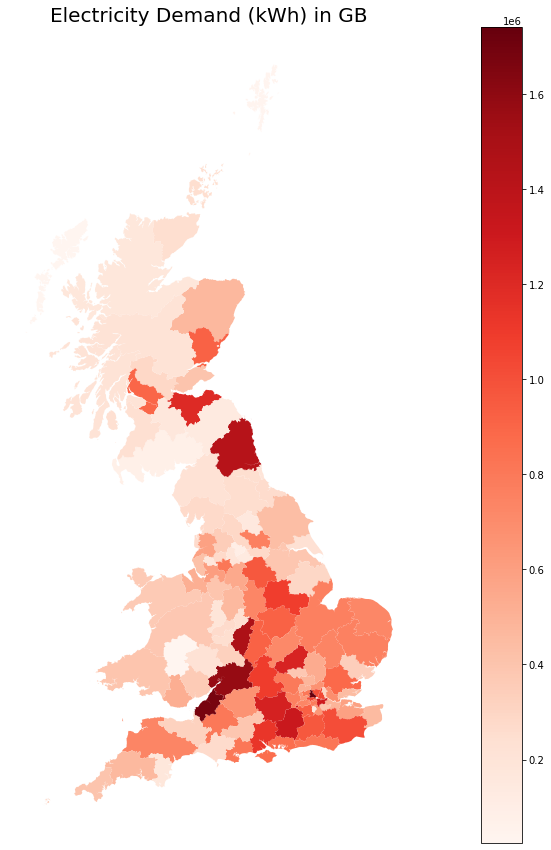

In [124]:
# draw the kWh map
bor_map = GeoDataFrame(df_map_consum)
hap='electricity_demand (kWh)'
vmin,vmax=bor_map[hap].min(),bor_map[hap].max()
fig,ax=plt.subplots(1,figsize=(25,15))
bor_map.plot(column=hap,cmap='Reds',ax=ax)
ax.axis('off')
plt.title('Electricity Demand (kWh) in GB',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [125]:
df_map_charger = pd.merge(uk_post,charging_kWh,how = 'left', left_on = 'PostArea', right_on='postcode_area')

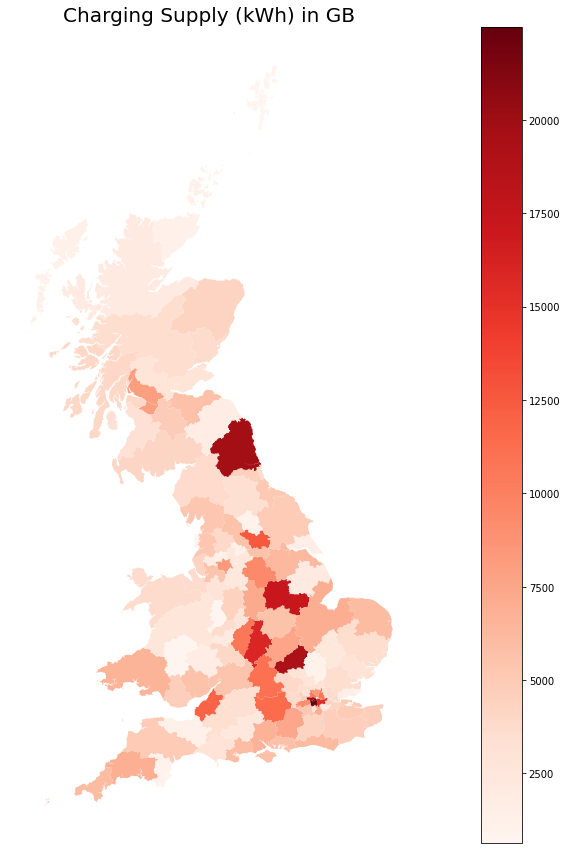

In [126]:
# draw the kWh map
bor_map = GeoDataFrame(df_map_charger)
hap='overall_kWh'
vmin,vmax=bor_map[hap].min(),bor_map[hap].max()
fig,ax=plt.subplots(1,figsize=(25,15))
bor_map.plot(column=hap,cmap='Reds',ax=ax)
ax.axis('off')
plt.title('Charging Supply (kWh) in GB',{'fontsize': '20',
 'fontweight' :'100'})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [127]:
charging_kWh.sort_values(by='overall_kWh',ascending = False).head(10)

,postcode_area,overall_kWh
101,SW,22474.3
71,NE,19747.0
112,W,19540.3
68,MK,19219.1
72,NG,17353.0
20,CV,15980.1
90,SE,15532.5
64,LS,12523.2
10,BS,11940.1
85,RG,11408.3


# Find the Relationship

## Overall

### Preprocessing

In [128]:
reg_demand_overall = pd.merge(merged_bev,merged_cars,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [129]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_methods,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [130]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_charger,how='left',on='postcode_area')

In [131]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_house,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [132]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_tenure,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [133]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_age,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [134]:
reg_demand_overall = pd.merge(reg_demand_overall,merged_edu,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [135]:
reg_demand_overall = pd.merge(reg_demand_overall,median_income,how='left',left_on='postcode_area',right_on='Postcode_Area').drop(['Postcode_Area'],axis=1)

In [136]:
reg_demand_overall = reg_demand_overall.dropna()

In [137]:
reg_demand_overall

,postcode_area,electricity_demand (kWh),vehicle_id,1 car,prop_1_car,2_more_cars,prop_2_car,prop_driving,overall_kWh,in_service_connect,fast_chargers_num,off_street,prop_flat,prop_rent,prop_own,prop_age_18_55,prop_high_edu,Total income: Median
0,NW,1740229,941,88258.0,0.517490,36091.0,0.211615,0.150915,10475.4,1230.0,265.0,53647.0,0.400599,0.306188,0.415635,0.481067,0.405483,38200.000000
1,BS,1685833,1034,172644.0,0.346676,140189.0,0.281505,0.407073,11940.1,514.0,292.0,194395.0,0.159364,0.185880,0.650384,0.412967,0.297748,25900.000000
2,GL,1575468,717,92263.0,0.305415,89428.0,0.296030,0.448752,5438.5,196.0,101.0,140343.0,0.121157,0.156501,0.697194,0.402730,0.303148,26316.666667
3,B,1477457,739,289967.0,0.386361,200225.0,0.266786,0.360429,10674.6,496.0,351.0,373253.0,0.185327,0.150327,0.608335,0.402938,0.227928,24940.000000
4,NE,1431530,698,218692.0,0.429937,128684.0,0.252986,0.353434,19747.0,1016.0,661.0,269175.0,0.173444,0.136143,0.596181,0.400944,0.241577,24060.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,HD,139969,85,34706.0,0.374661,25477.0,0.275032,0.407453,2303.0,71.0,35.0,42315.0,0.102968,0.169277,0.672476,0.411789,0.274947,24100.000000
113,HX,100214,58,33722.0,0.389328,23342.0,0.269488,0.417143,1345.4,59.0,34.0,34023.0,0.132667,0.161217,0.668842,0.413826,0.232529,25000.000000
114,DG,79878,42,28970.0,0.370707,21114.0,0.270180,0.586478,4163.0,162.0,126.0,41567.0,0.129282,0.136175,0.646568,0.442645,0.216768,23800.000000
116,ZE,34014,17,4206.0,0.316550,3843.0,0.289230,0.628058,644.0,40.0,34.0,8211.0,0.071156,0.085829,0.653869,0.480856,0.266314,27300.000000


In [138]:
day = (reg_demand_overall['electricity_demand (kWh)']/365)/24

In [139]:
reg_demand_overall['avg_hour'] = day/reg_demand_overall['overall_kWh']

In [140]:
reg_demand_overall['prop_fast_density'] = reg_demand_overall['fast_chargers_num']/reg_demand_overall['vehicle_id']

In [141]:
overall = reg_demand_overall.copy()

In [142]:
reg_demand_overall = reg_demand_overall[reg_demand_overall['postcode_area']!= 'ZE']

In [143]:
reg_demand_overall['log_demand'] = np.log(reg_demand_overall['electricity_demand (kWh)'])
reg_demand_overall['log_supply'] = np.log(reg_demand_overall['in_service_connect'])
reg_demand_overall['log_off_street'] = np.log(reg_demand_overall['off_street'])
reg_demand_overall['log_high_edu'] = np.log(reg_demand_overall['prop_high_edu'])
reg_demand_overall['log_1_car'] = np.log(reg_demand_overall['1 car'])
reg_demand_overall['log_income'] = np.log(reg_demand_overall['Total income: Median'])
reg_demand_overall['log_fast'] = np.log(reg_demand_overall['fast_chargers_num'])
reg_demand_overall['log_avg_hour'] = np.log(reg_demand_overall['avg_hour'])
reg_demand_overall['log_age_18_55'] = np.log(reg_demand_overall['prop_age_18_55'])
reg_demand_overall['log_fast_chargers'] = np.log(reg_demand_overall['prop_fast_density'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### VIF

In [144]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

In [145]:
vif_test = reg_demand_overall[['log_supply','log_off_street','log_high_edu','log_avg_hour','log_fast_chargers','log_income','log_age_18_55']]

In [146]:
variance_inflation_factors(vif_test)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                33881.892725
log_supply               4.544025
log_off_street           2.616376
log_high_edu             2.828677
log_avg_hour             2.524128
log_fast_chargers        3.293860
log_income               3.468331
log_age_18_55            1.605046
Name: VIF, dtype: float64

### Overall Regression

In [147]:
# These lines extract the y-values and the x-values from the data:
x_values = reg_demand_overall[['log_supply','log_off_street','log_high_edu','log_avg_hour','log_fast_chargers','log_income','log_age_18_55']]
y_values = reg_demand_overall['log_demand']

# These lines perform the regression procedure:
X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()
# and print a summary of the results:
print(regression_model_b.summary())

                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     382.1
Date:                Wed, 31 Aug 2022   Prob (F-statistic):           3.82e-72
Time:                        19:24:08   Log-Likelihood:                 61.390
No. Observations:                 114   AIC:                            -106.8
Df Residuals:                     106   BIC:                            -84.89
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                13.1583      2.52

In [148]:
#reg_demand_overall.to_csv('reg_data.csv')

# Clustering

In [149]:
reg_demand_overall.iloc[:,10:]

,fast_chargers_num,off_street,prop_flat,prop_rent,prop_own,prop_age_18_55,prop_high_edu,Total income: Median,avg_hour,prop_fast_density,log_demand,log_supply,log_off_street,log_high_edu,log_1_car,log_income,log_fast,log_avg_hour,log_age_18_55,log_fast_chargers
0,265.0,53647.0,0.400599,0.306188,0.415635,0.481067,0.405483,38200.000000,0.018964,0.281615,14.369527,7.114769,10.890181,-0.902677,11.388020,10.550591,5.579730,-3.965209,-0.731750,-1.267213
1,292.0,194395.0,0.159364,0.185880,0.650384,0.412967,0.297748,25900.000000,0.016118,0.282398,14.337770,6.242223,12.177647,-1.211509,12.058987,10.161998,5.676754,-4.127839,-0.884386,-1.264436
2,101.0,140343.0,0.121157,0.156501,0.697194,0.402730,0.303148,26316.666667,0.033069,0.140865,14.270063,5.278115,11.851845,-1.193533,11.432398,10.177958,4.615121,-3.409147,-0.909488,-1.959955
3,351.0,373253.0,0.185327,0.150327,0.608335,0.402938,0.227928,24940.000000,0.015800,0.474966,14.205833,6.206576,12.830012,-1.478728,12.577522,10.124228,5.860786,-4.147741,-0.908972,-0.744512
4,661.0,269175.0,0.173444,0.136143,0.596181,0.400944,0.241577,24060.000000,0.008276,0.946991,14.174254,6.923629,12.503117,-1.420566,12.295420,10.088306,6.493754,-4.794454,-0.913933,-0.054465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,38.0,39298.0,0.199988,0.147336,0.613813,0.431248,0.256305,24500.000000,0.009375,0.593750,11.869340,4.290459,10.578929,-1.361386,10.338867,10.106428,3.637586,-4.669676,-0.841072,-0.521297
112,35.0,42315.0,0.102968,0.169277,0.672476,0.411789,0.274947,24100.000000,0.006938,0.411765,11.849176,4.262680,10.652897,-1.291176,10.454668,10.089967,3.555348,-4.970743,-0.887244,-0.887303
113,34.0,34023.0,0.132667,0.161217,0.668842,0.413826,0.232529,25000.000000,0.008503,0.586207,11.515063,4.077537,10.434792,-1.458739,10.425906,10.126631,3.526361,-4.767335,-0.882310,-0.534082
114,126.0,41567.0,0.129282,0.136175,0.646568,0.442645,0.216768,23800.000000,0.002190,3.000000,11.288256,5.087596,10.635062,-1.528927,10.274016,10.077441,4.836282,-6.123687,-0.814986,1.098612


In [150]:
overall = reg_demand_overall[['postcode_area','electricity_demand (kWh)','in_service_connect','off_street','avg_hour','prop_fast_density','Total income: Median']]

In [151]:
overall

,postcode_area,electricity_demand (kWh),in_service_connect,off_street,avg_hour,prop_fast_density,Total income: Median
0,NW,1740229,1230.0,53647.0,0.018964,0.281615,38200.000000
1,BS,1685833,514.0,194395.0,0.016118,0.282398,25900.000000
2,GL,1575468,196.0,140343.0,0.033069,0.140865,26316.666667
3,B,1477457,496.0,373253.0,0.015800,0.474966,24940.000000
4,NE,1431530,1016.0,269175.0,0.008276,0.946991,24060.000000
...,...,...,...,...,...,...,...
111,TD,142820,73.0,39298.0,0.009375,0.593750,24500.000000
112,HD,139969,71.0,42315.0,0.006938,0.411765,24100.000000
113,HX,100214,59.0,34023.0,0.008503,0.586207,25000.000000
114,DG,79878,162.0,41567.0,0.002190,3.000000,23800.000000


## Rescale the Clustering Data

In [152]:
# set up the MinMaxScaler
mms = MinMaxScaler(feature_range=(-1,1))

In [153]:
# move the postcode_area to the index before the rescale
clustering_data = overall.set_index('postcode_area')

In [154]:
# rescale the columns using the MinMaxScaler
for c in clustering_data.columns:
    clustering_data[c] = mms.fit_transform(clustering_data[c].values.reshape(-1,1))

In [155]:
clustering_data_ss = clustering_data.copy()

## K-Means

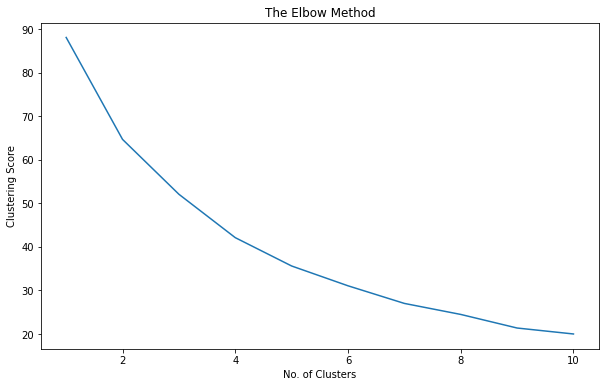

In [156]:
# from https://www.kaggle.com/satishgunjal/tutorial-k-means-clustering
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(clustering_data)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), clustering_score)
#plt.scatter(5,clustering_score[4], s = 200, c = 'red', marker='*')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()

.........
Largest silhouette score was 0.2930 for k=5


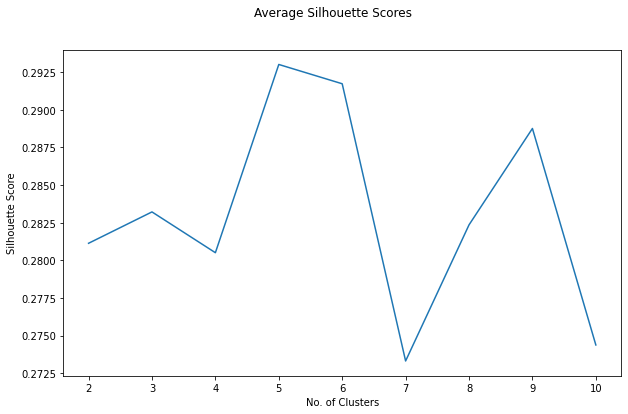

In [157]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,11):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k).fit(clustering_data)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(clustering_data, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.figure(figsize=(10,6))
plt.plot(y, x)
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.gcf().suptitle("Average Silhouette Scores");

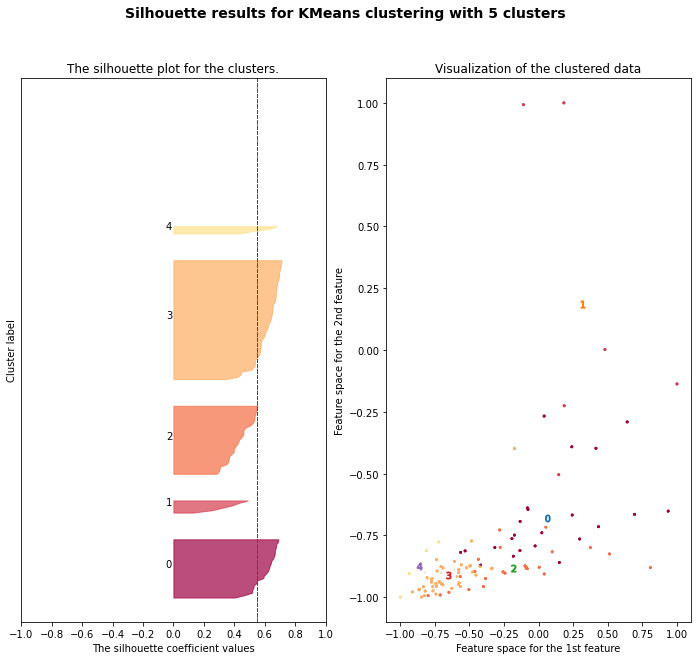

In [158]:
k_pref=5
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref).fit(clustering_data_ss)

# Convert to a series
s = pd.Series(kmeans.labels_, index=clustering_data_ss.index, name='K_Means')

# We do this for plotting
clustering_data_ss['K_Means'] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(clustering_data_ss, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(clustering_data_ss, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 10)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, clustering_data_ss.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=1.0)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(clustering_data_ss[clustering_data_ss.columns[0]], clustering_data_ss[clustering_data_ss.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

In [311]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(clustering_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 3, 0, 3, 3, 0, 2, 3, 3, 0, 3, 3, 3, 2, 2, 3, 2, 3, 0, 0, 3, 0,
       3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 1, 3, 3, 3, 0,
       0, 0, 0, 0, 3, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1,
       3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4], dtype=int32)

In [312]:
# add clustering labels
overall['Cluster Labels'] = kmeans.labels_

## Map the K-Means Result

In [313]:
# bring back the geo data to make map
overall_map = pd.merge(overall, uk_post, how='left',left_on='postcode_area',right_on='PostArea')

Text(0.5, 1.0, 'KMeans Results (k=5)')

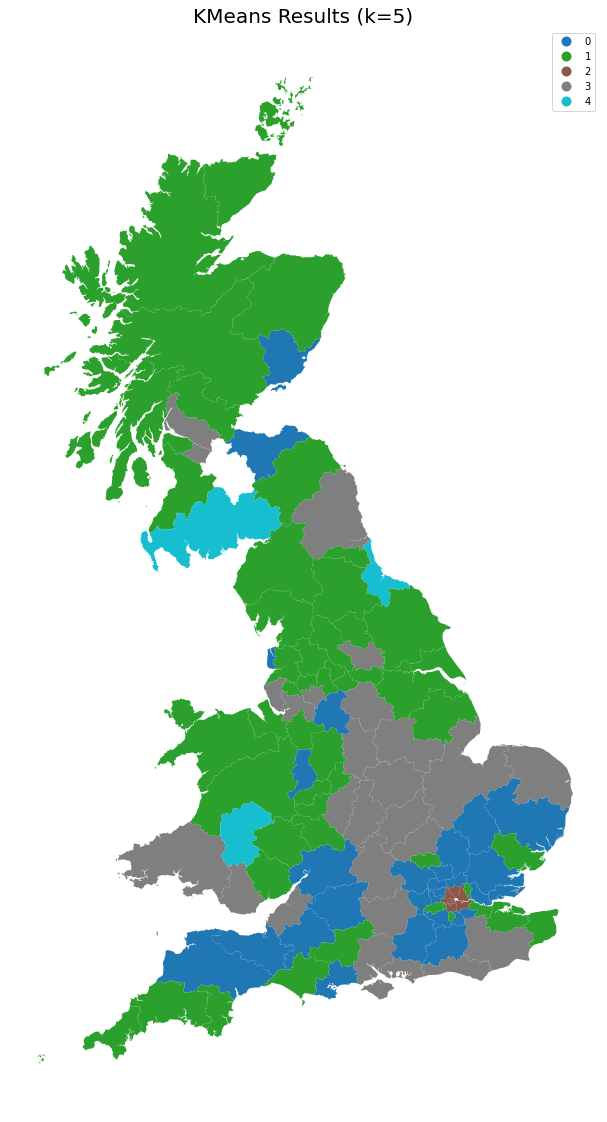

In [314]:
overall_map= GeoDataFrame(overall_map)

# set color map
cmap = plt.cm.seismic

# draw the reslut of clustering map
hap='Cluster Labels'
fig,ax=plt.subplots(1,figsize=(25,20))
overall_map.plot(column=hap,ax=ax,categorical=True,legend=True)
ax.axis('off')
plt.title(f"KMeans Results (k=5)",{'fontsize': '20',
 'fontweight' :'100'})

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3
Processing cluster 4


Text(0.5, 0.98, 'Each Clusters Performance in Centroids')

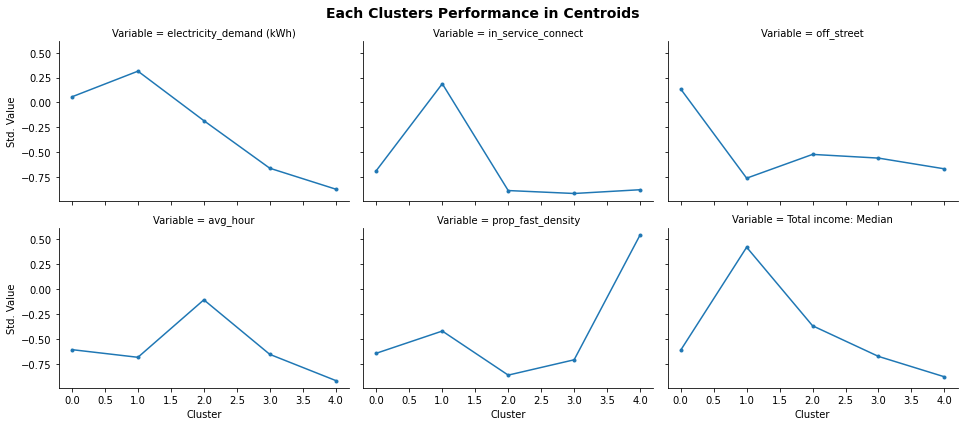

In [315]:
centroids = None
for k in sorted(clustering_data_ss['K_Means'].unique()):
    print(f"Processing cluster {k}")

    c = clustering_data_ss[clustering_data_ss['K_Means']==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index('K_Means')
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['LSOA11CD','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(('Each Clusters Performance in Centroids'),fontsize=14, fontweight='bold')

In [316]:
clustering_data_ss[clustering_data_ss['K_Means']==4]

,electricity_demand (kWh),in_service_connect,off_street,avg_hour,prop_fast_density,Total income: Median,K_Means
postcode_area,,,,,,,
TS,-0.723075,-0.777139,-0.184892,-0.861271,0.431291,-0.836773,4
SR,-0.811123,-0.811646,-0.646072,-0.862010,0.634346,-0.898687,4
DG,-0.935787,-0.905104,-0.826274,-1.000000,1.000000,-0.819887,4
LD,-1.000000,-1.000000,-1.000000,-0.925050,0.113951,-0.943715,4


In [317]:
overall = pd.merge(overall,merged_bev[['postcode_area','vehicle_id']],on='postcode_area',how = 'left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'vehicle_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  """Entry point for launching an IPython kernel.


In [318]:
overall

,postcode_area,electricity_demand (kWh),in_service_connect,off_street,avg_hour,prop_fast_density,Total income: Median,Cluster Labels,vehicle_id_x,vehicle_id_y,vehicle_id_x,vehicle_id_y
0,NW,1740229,1230.0,53647.0,0.018964,0.281615,38200.000000,2,941,941,941,941
1,BS,1685833,514.0,194395.0,0.016118,0.282398,25900.000000,3,1034,1034,1034,1034
2,GL,1575468,196.0,140343.0,0.033069,0.140865,26316.666667,0,717,717,717,717
3,B,1477457,496.0,373253.0,0.015800,0.474966,24940.000000,3,739,739,739,739
4,NE,1431530,1016.0,269175.0,0.008276,0.946991,24060.000000,3,698,698,698,698
...,...,...,...,...,...,...,...,...,...,...,...,...
109,TD,142820,73.0,39298.0,0.009375,0.593750,24500.000000,1,64,64,64,64
110,HD,139969,71.0,42315.0,0.006938,0.411765,24100.000000,1,85,85,85,85
111,HX,100214,59.0,34023.0,0.008503,0.586207,25000.000000,1,58,58,58,58
112,DG,79878,162.0,41567.0,0.002190,3.000000,23800.000000,4,42,42,42,42


# Examine Clustering Result

## Get Each Label

In [319]:
# extract cluster Labels = 0
group0 = overall.loc[overall['Cluster Labels'] == 0,
                     overall.columns[[0] + list(range(1, overall.shape[1]))]]

In [320]:
# extract cluster Labels = 1
group1 = overall.loc[overall['Cluster Labels'] == 1,
                     overall.columns[[0] + list(range(1, overall.shape[1]))]]

In [321]:
# extract cluster Labels = 2
group2 = overall.loc[overall['Cluster Labels'] == 2,
                     overall.columns[[0] + list(range(1, overall.shape[1]))]]

In [322]:
# extract cluster Labels = 3
group3 = overall.loc[overall['Cluster Labels'] == 3,
                     overall.columns[[0] + list(range(1, overall.shape[1]))]]

In [323]:
# extract cluster Labels = 0
group4 = overall.loc[overall['Cluster Labels'] == 4,
                     overall.columns[[0] + list(range(1, overall.shape[1]))]]

In [324]:
group0['Cluster Labels'].count()

29

In [325]:
group1['Cluster Labels'].count()

50

In [326]:
group2['Cluster Labels'].count()

6

In [327]:
group3['Cluster Labels'].count()

25

In [328]:
group4['Cluster Labels'].count()

4

## View Electricity Demand

In [329]:
# average electricity_demand for group 0
group0['electricity_demand (kWh)'].agg('mean')

726420.3103448276

In [330]:
# average electricity_demand for group 1
group1['electricity_demand (kWh)'].agg('mean')

318044.46

In [331]:
# average electricity_demand for group 2
group2['electricity_demand (kWh)'].agg('mean')

1151574.0

In [332]:
# average electricity_demand for group 2
group3['electricity_demand (kWh)'].agg('mean')

931398.6

In [333]:
# average electricity_demand for group 2
group4['electricity_demand (kWh)'].agg('mean')

138452.0

## View Supply

In [334]:
# average electricity_supply for group 0
group0['in_service_connect'].agg('mean')

194.58620689655172

In [335]:
# average electricity_supply for group 1
group1['in_service_connect'].agg('mean')

153.68

In [336]:
# average electricity_supply for group 2
group2['in_service_connect'].agg('mean')

1682.3333333333333

In [284]:
# average electricity_supply for group 2
group3['in_service_connect'].agg('mean')

1875.0

In [285]:
# average electricity_supply for group 2
group4['in_service_connect'].agg('mean')

138.55769230769232

## View Off Street

In [286]:
# average off street proportion for group 0
group0['off_street'].agg('mean')

96203.46428571429

In [287]:
# average off street proportion for group 0
group1['off_street'].agg('mean')

62655.666666666664

In [288]:
# average off street proportion for group 0
group2['off_street'].agg('mean')

220584.34782608695

In [289]:
# average off street proportion for group 0
group3['off_street'].agg('mean')

51552.4

In [290]:
# average off street proportion for group 0
group4['off_street'].agg('mean')

98094.25

## View Demand/Supply

In [291]:
# average rent proportion for group 0
group0['avg_hour'].agg('mean')

0.024557501741560978

In [292]:
# average rent proportion for group 0
group1['avg_hour'].agg('mean')

0.005050929101602466

In [293]:
# average rent proportion for group 0
group2['avg_hour'].agg('mean')

0.012822630085920364

In [294]:
# average rent proportion for group 0
group3['avg_hour'].agg('mean')

0.009923153077608774

In [295]:
# average rent proportion for group 0
group4['avg_hour'].agg('mean')

0.012386117360156452

## Fast Charger/BEV

In [296]:
# median income proportion for group 0
group0['prop_fast_density'].agg('mean')

0.3804133860847063

In [297]:
# median income proportion for group 0
group1['prop_fast_density'].agg('mean')

1.9823998112858316

In [298]:
# median income proportion for group 0
group2['prop_fast_density'].agg('mean')

0.6531136885740303

In [299]:
# median income proportion for group 0
group3['prop_fast_density'].agg('mean')

1.0664187832782006

In [300]:
# median income proportion for group 0
group4['prop_fast_density'].agg('mean')

0.5176428654546009

## Income

In [301]:
# median income proportion for group 0
group0['Total income: Median'].agg('mean')

28485.962301587304

In [302]:
# median income proportion for group 0
group1['Total income: Median'].agg('mean')

24525.0

In [303]:
# median income proportion for group 0
group2['Total income: Median'].agg('mean')

25811.354382332644

In [304]:
# median income proportion for group 0
group3['Total income: Median'].agg('mean')

35335.33333333333

In [305]:
# median income proportion for group 0
group4['Total income: Median'].agg('mean')

24869.555860805864

## Num of BEV

In [306]:
# median income proportion for group 0
group0['vehicle_id'].agg('median')

366.0

In [307]:
# median income proportion for group 0
group1['vehicle_id'].agg('median')

84.5

In [308]:
# median income proportion for group 0
group2['vehicle_id'].agg('median')

506.0

In [309]:
# median income proportion for group 0
group3['vehicle_id'].agg('mean')

582.0

In [310]:
# median income proportion for group 0
group4['vehicle_id'].agg('mean')

171.25